In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import metrics
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import AlphaSelection
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification


import warnings
warnings.filterwarnings("ignore")

In [2]:
def data_cleaning():
    # read data
    house_df = pd.read_csv('assets/updated_house_df.csv')
    
    # add covid dummy
    house_df['is_covid'] = 0
    house_df.loc[(house_df['covid_cases'] > 0), 'is_covid'] = 1
    # clean 1.5% outliers
    tsp = house_df.total_sale_price
    l, r = np.percentile(tsp, [1, 99.5])
    house_df = house_df[(house_df["total_sale_price"] > l) &
                        (house_df["total_sale_price"] < r)]
    # drop zip == 0
    house_df = house_df[(house_df["physical_zip_code"] != 0)]
    
    # log total_sale_price 
    house_df['log_px'] = np.log10(house_df["total_sale_price"])
    return house_df

house_df = data_cleaning()

In [3]:
house_df.head()

,deed_date,land_sale_price,total_sale_price,assessed_building_value,story_height,heated_area,bath,bath_fixtures,physical_zip_code,physical_city,...,year,crime,electric,gas,water,sewer,all,assessed_value_per_heated_area,covid_year_timeline,log_px
0,2000-01-01,0.0,145000.0,158106.0,2.0,1600,2.0,0,27609,raleigh,...,2000,2049,1,1,1,1,1,98.816250,-20,5.161368
2,2000-01-01,0.0,170000.0,178501.0,1.0,1937,2.0,0,27511,cary,...,2000,78,1,1,1,1,1,92.153330,-20,5.230449
4,2000-01-01,0.0,179000.0,73083.0,1.0,2510,3.0,0,27612,raleigh,...,2000,2049,1,1,1,1,1,29.116733,-20,5.252853
5,2000-01-01,0.0,44000.0,37216.0,1.0,928,1.0,0,27603,raleigh,...,2000,2049,1,1,1,1,1,40.103448,-20,4.643453
6,2000-01-01,0.0,165000.0,205423.0,1.0,2098,2.5,0,27511,cary,...,2000,78,1,1,1,1,1,97.913727,-20,5.217484


In [4]:
def add_features(house_df,
                 start_year=None,
                 end_year=None,
                 test_size=0.2,
                 random_seed=42
                ):
    yvar = "log_px"
    xvar_dict = dict()

    reg_df = house_df.copy()
    
    if start_year is not None:
        reg_df = reg_df[(reg_df.deed_date >= str(start_year)+"-01-01")]
    if end_year is not None:
        reg_df = reg_df[(reg_df.deed_date <= str(end_year)+"-12-31")]


    intercept = ["I"]
    macro = ["mort_rate", "lumber_price", "metals_price"]
    #### story
    # base case is story==2, each of below variable represents difference to story==2
    story = ["I_story1", "I_story1-2", "I_story_other"]

    reg_df["is_covid"] = 0
    reg_df.loc[reg_df["covid_cases"] > 0, "is_covid"] = 1

    reg_df["I_story1"] = 0
    reg_df.loc[(reg_df["story_height"] == 1), "I_story1"] = 1

    reg_df["I_story1-2"] = 0
    reg_df.loc[(reg_df["story_height"] > 1) &
               (reg_df["story_height"] < 2), "I_story1-2"] = 1

    reg_df["I_story_other"] = 0
    reg_df.loc[(reg_df["story_height"] > 2), "I_story_other"] = 1

    #### bath
    bath = ["I_bath_unknown", "bath"]
    reg_df["I_bath_unknown"] = 0
    reg_df.loc[(reg_df["bath"] == 0), "I_bath_unknown"] = 1

    #### heated area
    reg_df["log_heated_area"] = np.log10(reg_df["heated_area"])

    #### zip 27587 has the most number of the observations. so we set it as a benchmark.
    all_zips = reg_df["physical_zip_code"].unique().tolist()
    zip_vars = []
    for z in all_zips:
        if z == 27587:
            continue
        zip_var = f"I_zip{z}"
        zip_vars.append(zip_var)
        reg_df[zip_var] = 0
        reg_df.loc[(reg_df["physical_zip_code"] == z), zip_var] = 1

    #### zip interaction with covid
    zip_covid = []
    for z in zip_vars:
        col = z + "_covid"
        zip_covid.append(col)
        reg_df[col] = reg_df[z] * reg_df["is_covid"]

    zip_vars = [z for z in zip_vars if z != "I_27587"]

    #### bath interaction with covid
    #### The relative impact of covid to each zip code relative to 27587
    reg_df["bath_covid"] = reg_df["bath"] * reg_df["is_covid"]
    reg_df["I_story1_covid"] = reg_df["I_story1"] * reg_df["is_covid"]
    reg_df["I_story1-2_covid"] = reg_df["I_story1-2"] * reg_df["is_covid"]
    reg_df["I_story_other_covid"] = reg_df["I_story_other"] * reg_df["is_covid"]

    #### regression
    potential_xvars = intercept + macro + story + bath + ['gas', 'sewer', 'crime', 'log_heated_area'] +\
        ["bath_covid","I_story1_covid","I_story1-2_covid","I_story_other_covid"]+\
        ['is_covid'] + zip_vars + zip_covid

    reg_df["I"] = 1
    reg_df = reg_df[(reg_df[[yvar]+potential_xvars].notnull().all(axis=1))]

    X, y = reg_df[potential_xvars], reg_df[yvar]
    from sklearn.model_selection import train_test_split
    if test_size == 0:
        X_train, X_test, y_train, y_test = X, X.iloc[:0], y, y.iloc[:0]
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)
    
    # Demeaning
    demean_ls = ['log_heated_area', 'mort_rate', 'lumber_price', 'metals_price']
    items0 = []
    for item in demean_ls:
        item0 = f"{item}0"
        items0.append(item0)

    for i in range(len(demean_ls)):
        item, item0 = demean_ls[i], items0[i]
        X_train[item0] = X_train[item] - X_train[item].mean()
        if test_size != 0:
            X_test[item0] = X_test[item] - X_train[item].mean()

    # bath want to demean by 2
    X_train["bath0"] = X_train["bath"] - 2
    X_train["bath0_covid"] = X_train["bath0"] * X_train["is_covid"]

    ## X_train,X_test interaction
    X_train["log_heated_area0_covid"] = X_train["is_covid"] * X_train["log_heated_area0"]
    
    if test_size != 0:
        X_test["bath0"] = X_test["bath"] - 2
        X_test["bath0_covid"] = X_test["bath0"] * X_test["is_covid"]
        X_test["log_heated_area0_covid"] = X_test["is_covid"] * X_test["log_heated_area0"]

    macro0 = [c + "0" for c in macro]
    
    xvar_dict["I"] = ["I"]
    xvar_dict["mort_rate0"] = ["mort_rate0"]
    xvar_dict["lumber_price0"] = ["lumber_price0"]
    xvar_dict["metals_price0"] = ["metals_price0"]
    xvar_dict["log_heated_area0"] = ["log_heated_area0"]
    xvar_dict["gas"] = ["gas"]
    xvar_dict["sewer"] = ["sewer"]
    xvar_dict["crime"] = ["crime"]
    xvar_dict["story"] = story
    xvar_dict["bath0"] = ["bath0"]
    xvar_dict["is_covid"] = ["is_covid"]
    xvar_dict["bath0_covid"] = ["bath0_covid"]
    xvar_dict["log_heated_area0_covid"] = ["log_heated_area0_covid"]
    xvar_dict["story_covid"] = ["I_story1_covid","I_story1-2_covid","I_story_other_covid"]
    xvar_dict["zip"] = zip_vars
    xvar_dict["zip_covid"] = zip_covid
    groups = ["I", "mort_rate0", "lumber_price0", "metals_price0", "log_heated_area0", "gas", "sewer", "crime",
              "story", "bath0", "is_covid", "bath0_covid", "log_heated_area0_covid", "story_covid",
              "zip", "zip_covid"]
    return X_train, X_test, y_train, y_test, xvar_dict, groups

## Linear Regression 

### Results using full dataset

In [5]:
X_train, X_test, y_train, y_test, xvar_dict, groups = add_features(house_df,
                                                                   start_year=None,
                                                                   end_year=None
                                                                  )

# full model
xvars = []
for g in groups:
    xvars += xvar_dict[g]
X_train_tmp, X_test_tmp = X_train[xvars], X_test[xvars]
reg_model = sm.OLS(y_train, X_train_tmp).fit()
full_model = reg_model

In [6]:
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_px   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     6232.
Date:                Fri, 21 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:54:00   Log-Likelihood:             1.1162e+05
No. Observations:              217324   AIC:                        -2.231e+05
Df Residuals:                  217246   BIC:                        -2.223e+05
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
I                          5.3668      0.002   3200.455      0.000       5.363       5.370
mort_rate0                -0.0131      0.000    -42.588      0.000      -0.014      -0.012
lumber_price0              0.0003   8.93e-06     37.697      0.000       0.000       0.000
metals_price0              0.0004   6.48e-06     54.566      0.000       0.000       0.000
log_heated_area0           0.9112      0.003    294.788      0.000       0.905       0.917
gas                        0.0175      0.002     11.498      0.000       0.015       0.021
sewer                     -0.0186      0.002    -11.495      0.000      -0.022      -0.015
crime                   -8.68e-06   7.41e-07    -11.707      0.000   -1.01e-05   -7.23e-06
I_story1                   0.0225      0.001     22.857      0.000       0.021       0.024
I_story1-2                 0.0323      0.001     34.220      0.000       0.030       0.034
I_story_other             -0.0889      0.006    -15.808      0.000      -0.100      -0.078
bath0                      0.0441      0.001     53.081      0.000       0.042       0.046
is_covid                   0.0614      0.003     19.120      0.000       0.055       0.068
bath0_covid               -0.0143      0.002     -8.796      0.000      -0.017      -0.011
log_heated_area0_covid    -0.1156      0.006    -19.138      0.000      -0.127      -0.104
I_story1_covid             0.0126      0.002      6.606      0.000       0.009       0.016
I_story1-2_covid          -0.0031      0.002     -1.673      0.094      -0.007       0.001
I_story_other_covid        0.0176      0.010      1.801      0.072      -0.002       0.037
I_zip27609                 0.0009      0.003      0.307      0.759      -0.005       0.006
I_zip27511                -0.0151      0.003     -5.918      0.000      -0.020      -0.010
I_zip27612                 0.0435      0.003     16.575      0.000       0.038       0.049
I_zip27603                -0.0074      0.002     -3.000      0.003      -0.012      -0.003
I_zip27610                -0.1019      0.002    -44.408      0.000      -0.106      -0.097
I_zip27604                -0.0289      0.003    -11.278      0.000      -0.034      -0.024
I_zip27502                 0.0382      0.002     17.809      0.000       0.034       0.042
I_zip27613                 0.0416      0.002     16.856      0.000       0.037       0.046
I_zip27591                -0.0618      0.003    -19.780      0.000      -0.068      -0.056
I_zip27529                -0.0833      0.003    -33.114      0.000      -0.088      -0.078
I_zip27615                 0.0233      0.002      9.496      0.000       0.018       0.028
I_zip27597                -0.0823      0.004    -22.913      0.000      -0.089      -0.075
I_zip27539                 0.0223      0.003      8.466      0.000       0.017  

#### full model cv

In [75]:
from sklearn.model_selection import KFold

def create_regression_cv(X, y, xvars):
    t0 = time.time()
    X1 = X[xvars]
    scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train, test in kf.split(X1):
        X_train, X_test, y_train, y_test = X1.iloc[train, :], X1.iloc[test, :], y.iloc[train], y.iloc[test]
        reg_model = sm.OLS(y_train, X_train).fit()
        score = 1 - metrics.mean_squared_error(y_test, reg_model.predict(X_test)) / y_test.var()
        scores.append(score)
    print(f"regression cross validation used {time.time()-t0} seconds")
    return np.mean(scores)

X, X_test, y, y_test, xvar_dict, groups = add_features(house_df,
                                                       start_year=None,
                                                       end_year=None,
                                                       test_size=0
                                                      )
xvars = []
for g in groups:
    xvars += xvar_dict[g]
create_regression_cv(X, y, xvars)

regression cross validation used 12.464936017990112 seconds


0.6892370887076513

#### House price changes after covid by zip code using full dataset

Text(0.5, 0, 'avg price pre_COVID by zip')

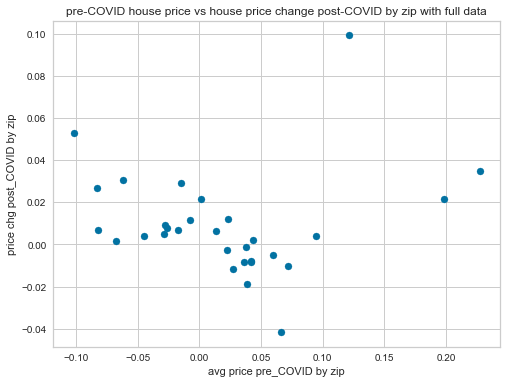

In [8]:
df_house_copy = house_df.copy()
all_zips = df_house_copy[(df_house_copy["physical_zip_code"]) != 27587]['physical_zip_code'].unique().tolist()

res = full_model.params[xvar_dict["zip"]].reset_index() # price by zip
res["zip_covid"] = full_model.params[xvar_dict["zip_covid"]].values # price chg after covide by zip
res["zip"] = all_zips
res = res.drop("index", axis=1)

counts = df_house_copy.groupby("physical_zip_code").apply(len).reset_index()
counts.columns = ["zip", "cnts"]
res = pd.merge(res, counts, on="zip")
res = res[(res.cnts > 300)]

fig, ax = plt.subplots(figsize=[8,6])
ax.scatter(res[0], res["zip_covid"])
ax.set_title("pre-COVID house price vs house price change post-COVID by zip with full data")
ax.set_ylabel("price chg post_COVID by zip")
ax.set_xlabel("avg price pre_COVID by zip")

### Results using data after 2017

In [9]:
X_train, X_test, y_train, y_test, xvar_dict, groups = add_features(house_df,
                                                                   start_year=2017,
                                                                   end_year=None
                                                                  )

# full model
xvars = []
for g in groups:
    xvars += xvar_dict[g]
X_train_tmp, X_test_tmp = X_train[xvars], X_test[xvars]
reg_model_2017 = sm.OLS(y_train, X_train_tmp).fit()
reg_model_2017.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_px   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     2448.
Date:                Fri, 21 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:54:20   Log-Likelihood:                 58136.
No. Observations:              110854   AIC:                        -1.161e+05
Df Residuals:                  110776   BIC:                        -1.154e+05
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
I                          5.4142      0.003   1981.673      0.000       5.409       5.420
mort_rate0                 0.0150      0.001     19.959      0.000       0.014       0.016
lumber_price0           4.713e-05   9.95e-06      4.736      0.000    2.76e-05    6.66e-05
metals_price0              0.0004   8.82e-06     45.405      0.000       0.000       0.000
log_heated_area0           0.8585      0.005    158.445      0.000       0.848       0.869
gas                        0.0222      0.002     10.342      0.000       0.018       0.026
sewer                     -0.0213      0.002     -9.384      0.000      -0.026      -0.017
crime                   1.956e-05   1.02e-06     19.114      0.000    1.76e-05    2.16e-05
I_story1                   0.0345      0.002     20.304      0.000       0.031       0.038
I_story1-2                 0.0305      0.002     19.125      0.000       0.027       0.034
I_story_other             -0.0876      0.009    -10.268      0.000      -0.104      -0.071
bath0                      0.0436      0.001     30.189      0.000       0.041       0.046
is_covid                   0.0742      0.004     19.435      0.000       0.067       0.082
bath0_covid               -0.0132      0.002     -6.640      0.000      -0.017      -0.009
log_heated_area0_covid    -0.0598      0.007     -8.035      0.000      -0.074      -0.045
I_story1_covid             0.0011      0.002      0.491      0.623      -0.003       0.006
I_story1-2_covid          -0.0025      0.002     -1.123      0.261      -0.007       0.002
I_story_other_covid        0.0247      0.012      2.084      0.037       0.001       0.048
I_zip27604                -0.0435      0.004    -10.607      0.000      -0.052      -0.035
I_zip27607                 0.1054      0.006     17.744      0.000       0.094       0.117
I_zip27545                -0.0605      0.004    -14.550      0.000      -0.069      -0.052
I_zip27608                 0.2107      0.006     34.201      0.000       0.199       0.223
I_zip27529                -0.0756      0.004    -17.623      0.000      -0.084      -0.067
I_zip27609                -0.0054      0.005     -1.182      0.237      -0.014       0.004
I_zip27511                 0.0101      0.004      2.289      0.022       0.001       0.019
I_zip27606                -0.0307      0.004     -6.896      0.000      -0.039      -0.022
I_zip27597                -0.0936      0.006    -16.858      0.000      -0.104      -0.083
I_zip27612                 0.0299      0.004      7.050      0.000       0.022       0.038
I_zip27591                -0.0382      0.005     -8.049      0.000      -0.048      -0.029
I_zip27610                -0.1026      0.004    -28.330      0.000      -0.110      -0.096
I_zip27603                -0.0238      0.004     -6.167      0.000      -0.031  

#### House price changes after covid by zip code since 2017 to update

Text(0.5, 0, 'avg price pre_COVID by zip')

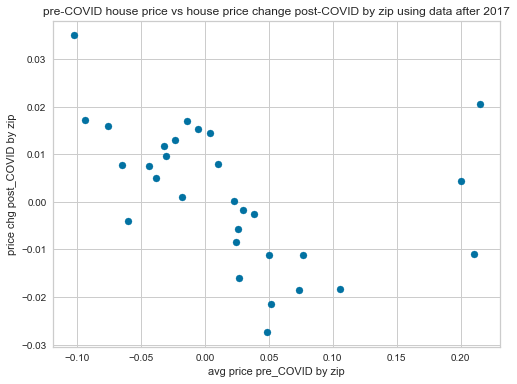

In [10]:
house_2017 = house_df[(house_df['year']>=2017)]
all_zips = house_2017[(house_2017["physical_zip_code"]) != 27587]['physical_zip_code'].unique().tolist()

res_2017 = reg_model_2017.params[xvar_dict["zip"]].reset_index() # price by zip
res_2017["zip_covid"] = reg_model_2017.params[xvar_dict["zip_covid"]].values # price chg after covide by zip
res_2017["zip"] = all_zips
res_2017 = res_2017.drop("index", axis=1)

counts = house_df.groupby("physical_zip_code").apply(len).reset_index()
counts.columns = ["zip", "cnts"]
res_2017 = pd.merge(res_2017, counts, on="zip")
res_2017 = res_2017[(res_2017.cnts > 300)]

fig, ax = plt.subplots(figsize=[8,6])
ax.scatter(res_2017[0], res_2017["zip_covid"])
ax.set_title("pre-COVID house price vs house price change post-COVID by zip using data after 2017")
ax.set_ylabel("price chg post_COVID by zip")
ax.set_xlabel("avg price pre_COVID by zip")

### Feature ablation for Linear Regression

In [11]:
X_train, X_test, y_train, y_test, xvar_dict, groups = add_features(house_df,
          start_year=None,
          end_year=None
         )

# full model
xvars = []
for g in groups:
    xvars += xvar_dict[g]
X_train_tmp, X_test_tmp = X_train[xvars], X_test[xvars]
reg_model = sm.OLS(y_train, X_train_tmp).fit()
full_model = reg_model
rg_y_pred = full_model.predict(X_test_tmp)
full_score = 1 - metrics.mean_squared_error(y_test, rg_y_pred) / y_test.var()
lr_full_score = full_score

# leave one out models
reg_results = dict()
reg_scores = dict()
for i in range(1, len(groups)):
    # select groups, by dropping i-th group
    xvars = []
    for j in range(len(groups)):
        if j == i:
            continue
        xvars += xvar_dict[groups[j]]
    X_train_tmp, X_test_tmp = X_train[xvars], X_test[xvars]

    reg_model = sm.OLS(y_train, X_train_tmp).fit()
    reg_results[groups[i]] = reg_model
    reg_scores[groups[i]] = 1 - metrics.mean_squared_error(y_test, reg_model.predict(X_test_tmp)) / y_test.var()

In [12]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, rg_y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, rg_y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, rg_y_pred)))

Mean Absolute Error: 0.09708225778104664
Mean Squared Error: 0.020391240497883288
Root Mean Squared Error: 0.14279790088752456


Text(0, 0.5, 'scores')

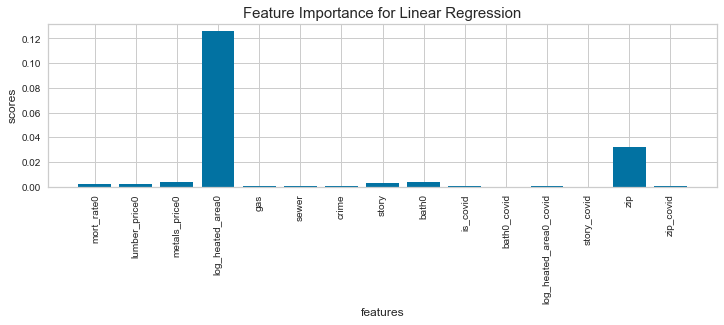

In [13]:
importance = pd.Series({k: full_score - reg_scores[k] for k in reg_scores})

fig, ax = plt.subplots(figsize=[12,3])
ax.bar(range(len(importance)), importance)
ax.set_xticks(range(len(importance)))
ax.set_xticklabels(importance.index, rotation=90)
plt.title('Feature Importance for Linear Regression', fontsize = 15) 
plt.xlabel('features', fontsize = 12) 
plt.ylabel('scores', fontsize = 12)

#### Cross-Validation Feature Ablation for linear regression

Text(0, 0.5, 'scores')

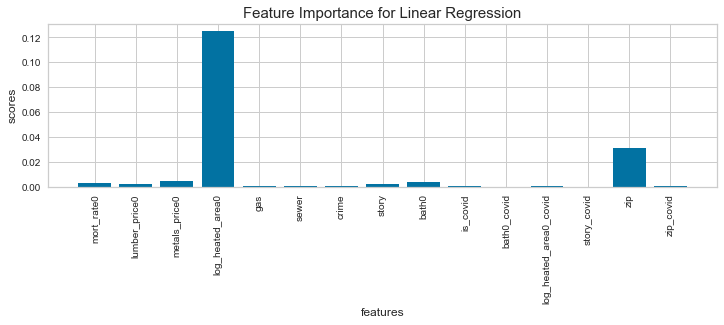

In [14]:
X, X_test, y, y_test, xvar_dict, groups = add_features(house_df,
                                                       start_year=None,
                                                       end_year=None,
                                                       test_size=0
                                                      )
# full model
xvars = []
for g in groups:
    xvars += xvar_dict[g]
lr_full_score = create_regression_cv(X, y, xvars)

# leave one out models
reg_results = dict()
reg_scores = dict()
for i in range(1, len(groups)):
    # select groups, by dropping i-th group
    xvars = []
    for j in range(len(groups)):
        if j == i:
            continue
        xvars += xvar_dict[groups[j]]
    reg_scores[groups[i]] = create_regression_cv(X, y, xvars)


importance = pd.Series({k: lr_full_score - reg_scores[k] for k in reg_scores})
fig, ax = plt.subplots(figsize=[12,3])
ax.bar(range(len(importance)), importance)
ax.set_xticks(range(len(importance)))
ax.set_xticklabels(importance.index, rotation=90)
plt.title('Feature Importance for Linear Regression', fontsize = 15) 
plt.xlabel('features', fontsize = 12) 
plt.ylabel('scores', fontsize = 12)

### Sensitivity analysis for Linear Regression

### Training size vs accuracy

each training size draw 10 times and take average score

In [22]:
reg_results = dict()
score_results = dict()

t0 = time.time()
for test_size in np.arange(0.1, 1, 0.1):
    seed_scores = []
    for seed in range(10):
        X_train, X_test, y_train, y_test, xvar_dict, groups = add_features(house_df,
                                                                           start_year=None,
                                                                           end_year=None,
                                                                           test_size=test_size,
                                                                           random_seed=seed)
        # full model
        xvars = []
        for g in groups:
            xvars += xvar_dict[g]
        X_train_tmp, X_test_tmp = X_train[xvars], X_test[xvars]
        reg_model = sm.OLS(y_train, X_train_tmp).fit()
        mse = metrics.mean_squared_error(y_test, reg_model.predict(X_test_tmp))
        reg_results[test_size] = reg_model
        seed_scores.append(1 - metrics.mean_squared_error(y_test, reg_model.predict(X_test_tmp)) / y_test.var())
    print(f"finished test size {test_size} {time.time() - t0}")
    score_results[test_size] = np.mean(seed_scores)

Text(0, 0.5, 'scores')

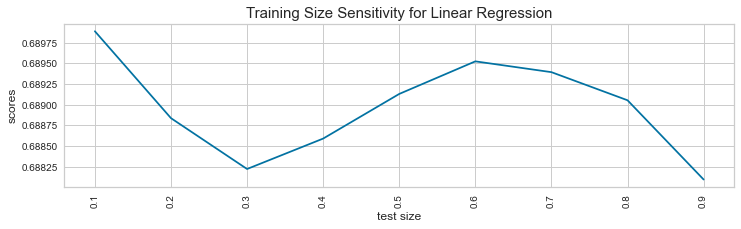

In [23]:
size_sensitivity = pd.Series(score_results).sort_index()

fig, ax = plt.subplots(figsize=[12,3])
ax.plot(size_sensitivity)
ax.set_xticks(size_sensitivity.index)
ax.set_xticklabels(np.round(size_sensitivity.index, 2), rotation=90)
plt.title('Training Size Sensitivity for Linear Regression', fontsize = 15)
plt.xlabel('test size', fontsize = 12)
plt.ylabel('scores', fontsize = 12)

### Year Sensitivity for Linear Regression

In [19]:
reg_results = dict()
score_results = dict()
for start_year in np.arange(2000, 2019, 1):
    X_train, X_test, y_train, y_test, xvar_dict, groups = add_features(house_df,
                                                                       start_year=start_year,
                                                                       end_year=None)
    # full model
    xvars = []
    for g in groups:
        xvars += xvar_dict[g]
    X_train_tmp, X_test_tmp = X_train[xvars], X_test[xvars]
    reg_model = sm.OLS(y_train, X_train_tmp).fit()
    mse = metrics.mean_squared_error(y_test, reg_model.predict(X_test_tmp))
    reg_results[start_year] = reg_model
    score_results[start_year] = 1 - metrics.mean_squared_error(y_test, reg_model.predict(X_test_tmp)) / y_test.var()

Text(0, 0.5, 'scores')

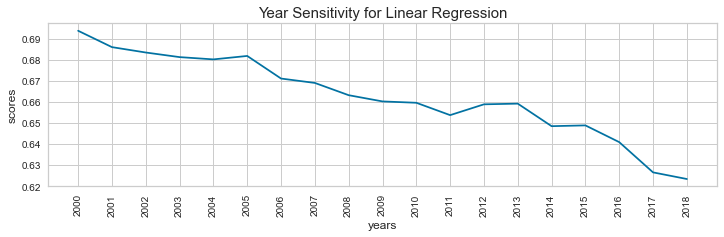

In [20]:
year_sensitivity = pd.Series(score_results).sort_index()

fig, ax = plt.subplots(figsize=[12,3])
ax.plot(year_sensitivity)
ax.set_xticks(year_sensitivity.index)
ax.set_xticklabels(np.round(year_sensitivity.index, 2), rotation=90)
plt.title('Year Sensitivity for Linear Regression', fontsize = 15) 
plt.xlabel('years', fontsize = 12) 
plt.ylabel('scores', fontsize = 12)

#### CV for Year Sensitivity for Linear Regression

In [30]:
X_train[xvars]

,I,mort_rate0,lumber_price0,metals_price0,log_heated_area0,gas,sewer,crime,I_story1,I_story1-2,...,I_zip27617_covid,I_zip27540_covid,I_zip27518_covid,I_zip27526_covid,I_zip27519_covid,I_zip27560_covid,I_zip27523_covid,I_zip27605_covid,I_zip27601_covid,I_zip27571_covid
0,1,3.889195,-43.77912,-117.943425,-0.120894,1,1,2049,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,3.889195,-43.77912,-117.943425,-0.037885,1,1,78,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,3.889195,-43.77912,-117.943425,0.074659,1,1,2049,1,0,...,0,0,0,0,0,0,0,0,0,0
5,1,3.889195,-43.77912,-117.943425,-0.357466,1,1,2049,1,0,...,0,0,0,0,0,0,0,0,0,0
6,1,3.889195,-43.77912,-117.943425,-0.003209,1,1,78,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275842,1,1.089195,91.17088,157.249575,-0.046261,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
275843,1,1.089195,91.17088,157.249575,-0.099705,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
275844,1,1.089195,91.17088,157.249575,-0.128838,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
275845,1,1.089195,91.17088,157.249575,-0.032094,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
reg_results = dict()
score_results = dict()
for start_year in np.arange(2000, 2019, 1):
    X_train, X_test, y_train, y_test, xvar_dict, groups = add_features(house_df,
                                                                       start_year=start_year,
                                                                       end_year=None,
                                                                       test_size=0)
    # full model
    xvars = []
    for g in groups:
        xvars += xvar_dict[g]
    X_train_tmp = X_train[xvars]
    score_results[start_year] = create_regression_cv(X_train_tmp, y_train, xvars)

regression cross validation used 11.125209093093872 seconds
regression cross validation used 10.715648889541626 seconds
regression cross validation used 11.237958908081055 seconds
regression cross validation used 10.1441171169281 seconds
regression cross validation used 9.820088148117065 seconds
regression cross validation used 9.498172998428345 seconds
regression cross validation used 9.46114993095398 seconds
regression cross validation used 8.848317861557007 seconds
regression cross validation used 8.412436962127686 seconds
regression cross validation used 8.419881820678711 seconds
regression cross validation used 7.796950101852417 seconds
regression cross validation used 8.686802864074707 seconds
regression cross validation used 9.253467798233032 seconds
regression cross validation used 7.039999008178711 seconds
regression cross validation used 6.419120788574219 seconds
regression cross validation used 5.86766505241394 seconds
regression cross validation used 5.180888891220093 secon

Text(0, 0.5, 'scores')

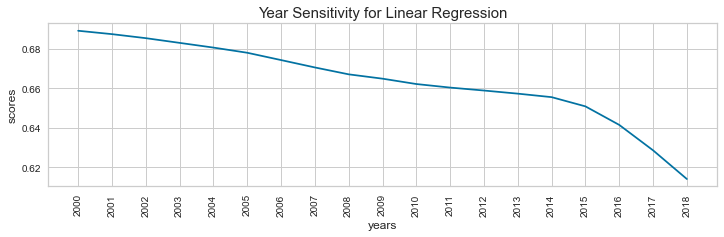

In [32]:
year_sensitivity = pd.Series(score_results).sort_index()

fig, ax = plt.subplots(figsize=[12,3])
ax.plot(year_sensitivity)
ax.set_xticks(year_sensitivity.index)
ax.set_xticklabels(np.round(year_sensitivity.index, 2), rotation=90)
plt.title('Year Sensitivity for Linear Regression', fontsize = 15) 
plt.xlabel('years', fontsize = 12) 
plt.ylabel('scores', fontsize = 12)

## Random Forest

In [62]:
X_train, X_test, y_train, y_test, xvar_dict, groups = add_features(house_df,
                                                                   start_year=None,
                                                                   end_year=None
                                                                  )

# full model
xvars = []
for g in groups:
    xvars += xvar_dict[g]
X_train_tmp, X_test_tmp = X_train[xvars], X_test[xvars]
rf_reg = RandomForestRegressor(n_estimators=20, max_depth=20, random_state=42)
rf_reg.fit(X_train_tmp, y_train)
full_model = rf_reg
rf_y_pred = full_model.predict(X_test_tmp)
full_score = rf_reg.score(X_test_tmp, y_test)
rf_full_score = full_score

# leave one out models
random_result = dict()
random_mse = dict()
for i in range(1, len(groups)):
    # select groups, by dropping i-th group
    xvars = []
    for j in range(len(groups)):
        if j == i:
            continue
        xvars += xvar_dict[groups[j]]
    X_train_tmp, X_test_tmp = X_train[xvars], X_test[xvars]
    rf_reg = RandomForestRegressor(n_estimators=20, random_state=42)
    rf_reg.fit(X_train_tmp, y_train)
    random_result[groups[i]] = rf_reg
    random_mse[groups[i]] = rf_reg.score(X_test_tmp, y_test)

In [63]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, rf_y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, rf_y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, rf_y_pred)))

Mean Absolute Error: 0.08902490967987314
Mean Squared Error: 0.018606146279388062
Root Mean Squared Error: 0.1364043484621662


In [64]:
xvars = []
for g in groups:
    xvars += xvar_dict[g]
pd.Series(full_model.feature_importances_, index=xvars).sort_values(ascending=False)

log_heated_area0          0.649593
log_heated_area0_covid    0.061847
is_covid                  0.044821
lumber_price0             0.043091
metals_price0             0.032925
                            ...   
I_zip27614_covid          0.000116
I_zip27560_covid          0.000092
I_zip27571_covid          0.000062
I_zip27617_covid          0.000042
I                         0.000000
Length: 78, dtype: float64

Text(0, 0.5, 'importance level')

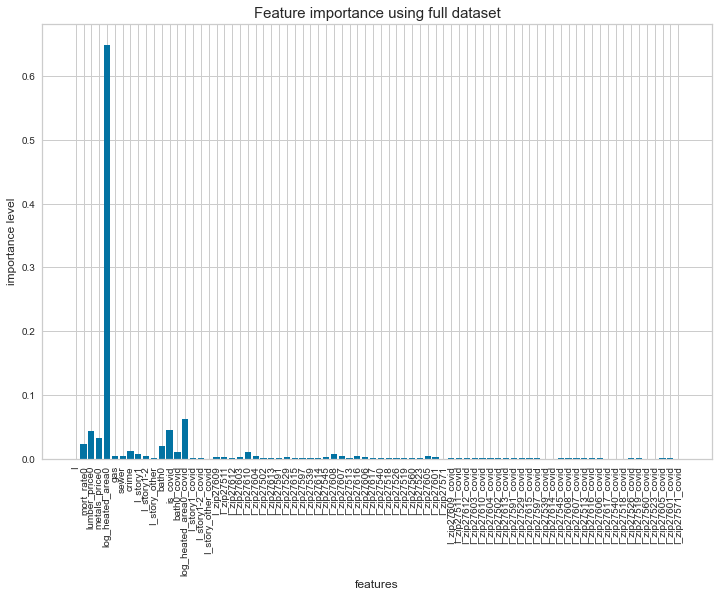

In [65]:
fig, ax = plt.subplots(figsize = [12,8])
ax.bar(range(len(xvars)), pd.Series(full_model.feature_importances_, index=xvars))
ax.set_xticks(range(len(xvars)))
ax.set_xticklabels(xvars, rotation=90)
plt.title('Feature importance using full dataset', fontsize = 15) 
plt.xlabel('features', fontsize = 12) 
plt.ylabel('importance level', fontsize = 12)

#### CV Function and Score for Full Random Forest Model

In [74]:
def create_rf_cv(X, y, xvars):
    t0 = time.time()
    X1 = X[xvars]
    scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train, test in kf.split(X1):
        X_train, X_test, y_train, y_test = X1.iloc[train, :], X1.iloc[test, :], y.iloc[train], y.iloc[test]
        rf_reg = RandomForestRegressor(n_estimators=20, max_depth=20, random_state=42)
        rf_reg.fit(X_train, y_train)
        score = 1 - metrics.mean_squared_error(y_test, rf_reg.predict(X_test)) / y_test.var()
        scores.append(score)
    print(f"random forest cv used {time.time()-t0} seconds")
    return np.mean(scores)

X, X_test, y, y_test, xvar_dict, groups = add_features(house_df,
                                                       start_year=None,
                                                       end_year=None,
                                                       test_size=0)
xvars = []
for g in groups:
    xvars += xvar_dict[g]
create_rf_cv(X, y, xvars)

random forest cv used 143.08605408668518 seconds


0.7178382230714238

### Random Forest using data after 2017

In [28]:
X_train, X_test, y_train, y_test, xvar_dict, groups = add_features(house_df,
                                                                   start_year=2017,
                                                                   end_year=None
                                                                  )
# full model
xvars = []
for g in groups:
    xvars += xvar_dict[g]
X_train_tmp, X_test_tmp = X_train[xvars], X_test[xvars]
rf_reg_2017 = RandomForestRegressor(n_estimators=20, max_depth=20, random_state=42)
rf_reg_2017.fit(X_train_tmp, y_train)
rf_y_pred_2017 = rf_reg_2017.predict(X_test_tmp)
rf_score_2017 = rf_reg_2017.score(X_test_tmp, y_test)

In [29]:
rf_score_2017

0.6188830084229033

In [30]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, rf_y_pred_2017))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, rf_y_pred_2017))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, rf_y_pred_2017)))

Mean Absolute Error: 0.09261532539099307
Mean Squared Error: 0.020937628547878187
Root Mean Squared Error: 0.14469840547800858


In [31]:
xvars = []
for g in groups:
    xvars += xvar_dict[g]
pd.Series(rf_reg_2017.feature_importances_, index=xvars).sort_values(ascending=False)

log_heated_area0          0.593628
log_heated_area0_covid    0.057873
metals_price0             0.053962
mort_rate0                0.037359
lumber_price0             0.031324
                            ...   
I_zip27571                0.000422
I_story_other_covid       0.000268
I_zip27617_covid          0.000237
I_zip27571_covid          0.000223
I                         0.000000
Length: 78, dtype: float64

Text(0, 0.5, 'importance level')

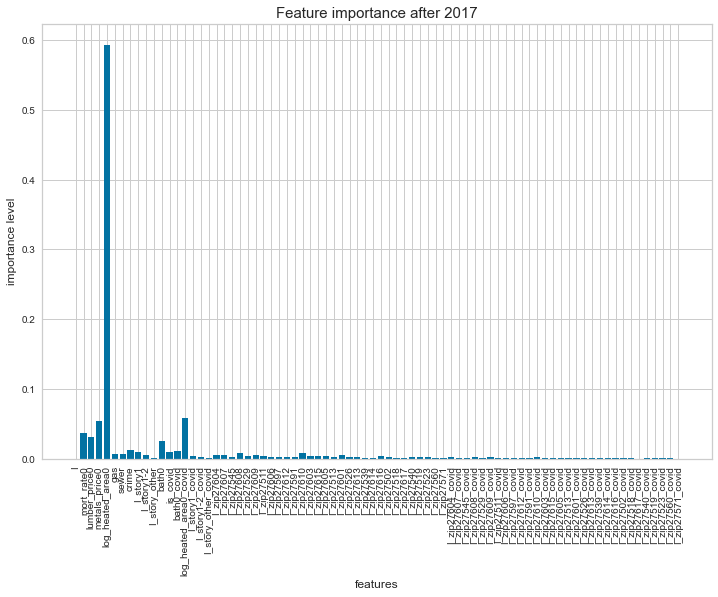

In [32]:
fig, ax = plt.subplots(figsize = [12,8])
ax.bar(range(len(xvars)), pd.Series(rf_reg_2017.feature_importances_, index=xvars))
ax.set_xticks(range(len(xvars)))
ax.set_xticklabels(xvars, rotation=90)
plt.title('Feature importance after 2017', fontsize = 15) 
plt.xlabel('features', fontsize = 12) 
plt.ylabel('importance level', fontsize = 12)

#### CV - Model Score after 2017 for Random Forest

In [33]:
X_train, X_test, y_train, y_test, xvar_dict, groups = add_features(house_df,
                                                                   start_year=2017,
                                                                   end_year=None,
                                                                   test_size=0)
# full model
xvars = []
for g in groups:
    xvars += xvar_dict[g]
create_rf_cv(X_train, y_train, xvars)

0.6355300032284008

### Feature ablation for Random Forest

In [34]:
X_train, X_test, y_train, y_test, xvar_dict, groups = add_features(house_df,
                                                                   start_year=None,
                                                                   end_year=None)
# full model
xvars = []
for g in groups:
    xvars += xvar_dict[g]
X_train_tmp, X_test_tmp = X_train[xvars], X_test[xvars]
rf_reg = RandomForestRegressor(n_estimators=50, max_depth=20, random_state=42)
rf_reg.fit(X_train_tmp, y_train)
full_model = rf_reg
rf_y_pred = full_model.predict(X_test_tmp)
full_score = rf_reg.score(X_test_tmp, y_test)
rf_full_score = full_score

# leave one out models
random_result = dict()
random_mse = dict()
for i in range(1, len(groups)):
    # select groups, by dropping i-th group
    xvars = []
    for j in range(len(groups)):
        if j == i:
            continue
        xvars += xvar_dict[groups[j]]
    X_train_tmp, X_test_tmp = X_train[xvars], X_test[xvars]
    rf_reg = RandomForestRegressor(n_estimators=20,max_depth=20, random_state=42)
    rf_reg.fit(X_train_tmp, y_train)
    random_result[groups[i]] = rf_reg
    random_mse[groups[i]] = rf_reg.score(X_test_tmp, y_test)

Text(0, 0.5, 'scores')

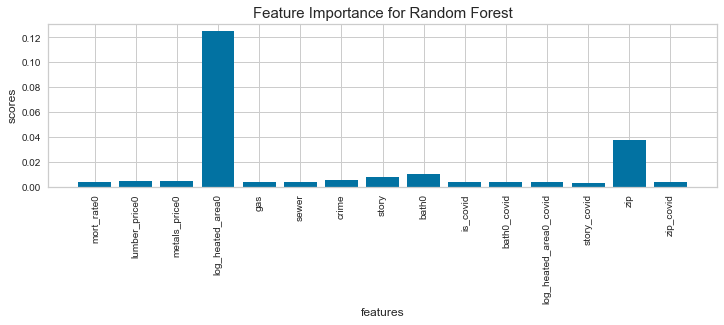

In [35]:
rf_importance = pd.Series({k: full_score - random_mse[k] for k in random_mse})

fig, ax = plt.subplots(figsize=[12,3])
ax.bar(range(len(rf_importance)), rf_importance)
ax.set_xticks(range(len(rf_importance)))
ax.set_xticklabels(rf_importance.index, rotation=90)
plt.title('Feature Importance for Random Forest', fontsize = 15) 
plt.xlabel('features', fontsize = 12) 
plt.ylabel('scores', fontsize = 12)

#### CV for Feature Ablation for Random Forest

random forest cv used 140.33453798294067 seconds
random forest cv used 136.2046821117401 seconds
random forest cv used 144.35347700119019 seconds
random forest cv used 135.61204934120178 seconds
random forest cv used 124.11873412132263 seconds
random forest cv used 148.30873918533325 seconds
random forest cv used 145.3657238483429 seconds
random forest cv used 166.2900836467743 seconds
random forest cv used 173.76023387908936 seconds
random forest cv used 175.4387047290802 seconds
random forest cv used 143.83841109275818 seconds
random forest cv used 142.27342534065247 seconds
random forest cv used 138.0179431438446 seconds
random forest cv used 141.09434390068054 seconds
random forest cv used 113.4531397819519 seconds
random forest cv used 123.86862707138062 seconds


Text(0, 0.5, 'scores')

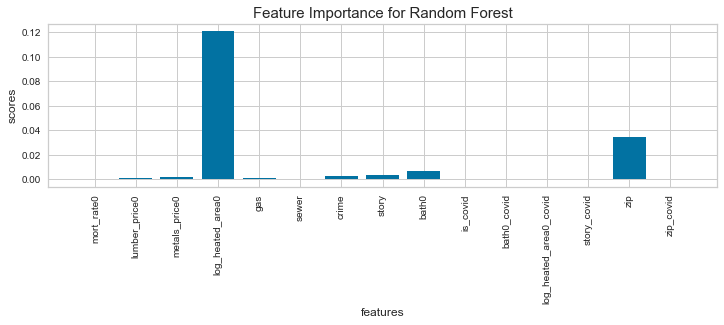

In [36]:
X, X_test, y, y_test, xvar_dict, groups = add_features(house_df,
                                                       start_year=None,
                                                       end_year=None,
                                                       test_size=0)
# full model
xvars = []
for g in groups:
    xvars += xvar_dict[g]
rf_full_score = create_rf_cv(X, y, xvars)

# leave one out models
reg_results = dict()
reg_scores = dict()
for i in range(1, len(groups)):
    # select groups, by dropping i-th group
    xvars = []
    for j in range(len(groups)):
        if j == i:
            continue
        xvars += xvar_dict[groups[j]]
    reg_scores[groups[i]] = create_rf_cv(X, y, xvars)

importance = pd.Series({k: rf_full_score - reg_scores[k] for k in reg_scores})
fig, ax = plt.subplots(figsize=[12,3])
ax.bar(range(len(importance)), importance)
ax.set_xticks(range(len(importance)))
ax.set_xticklabels(importance.index, rotation=90)
plt.title('Feature Importance for Random Forest', fontsize = 15)
plt.xlabel('features', fontsize = 12)
plt.ylabel('scores', fontsize = 12)

### Grid Search

In [71]:
X_train, X_test, y_train, y_test, xvar_dict, groups = add_features(house_df,
                                                                   start_year=None,
                                                                   end_year=None
                                                                  )


n_estimators = [20, 50, 100, 200]
max_depth = [5, 10, 20, 30]
rf_grid_scores = pd.DataFrame(index=n_estimators, columns=max_depth)
rf_grid_models = dict()

xvars = []
for g in groups:
    xvars += xvar_dict[g]
X_train_tmp, X_test_tmp = X_train[xvars], X_test[xvars]

for i in range(len(n_estimators)):
    n_est = n_estimators[i]
    rf_grid_models_by_depth = dict()
    for j in range(len(max_depth)):
        t0 = time.time()
        
        max_dep = max_depth[j]
        rf_reg = RandomForestRegressor(n_estimators=n_est, max_depth=max_dep, random_state=42)
        rf_reg.fit(X_train_tmp, y_train)
        rf_grid_models_by_depth[max_dep] = rf_reg
        rf_y_pred = rf_reg.predict(X_test_tmp)
        this_score = rf_reg.score(X_test_tmp, y_test)
        rf_grid_scores.loc[n_est, max_dep] = this_score
        
        print(f"finished {n_est} {max_dep} in {time.time()-t0}")
    rf_grid_models[n_est] = rf_grid_models_by_depth

finished 20 5 in 12.969819784164429
finished 20 10 in 23.587523937225342
finished 20 20 in 35.737688064575195
finished 20 30 in 46.195411920547485
finished 50 5 in 31.974704027175903
finished 50 10 in 61.32623600959778
finished 50 20 in 87.32987880706787
finished 50 30 in 100.09800219535828
finished 100 5 in 53.88168287277222
finished 100 10 in 105.82007813453674
finished 100 20 in 162.52803492546082
finished 100 30 in 200.78691244125366
finished 200 5 in 105.86260414123535
finished 200 10 in 244.33390402793884
finished 200 20 in 331.28292202949524
finished 200 30 in 985.9412291049957


In [72]:
rf_grid_scores.dtypes
rf_grid_scores= rf_grid_scores.astype(float)
rf_grid_scores

,5,10,20,30
20,0.651597,0.698820,0.720548,0.712771
50,0.651773,0.699817,0.724266,0.719242
100,0.651824,0.699890,0.725707,0.721567
200,0.651785,0.700164,0.726516,0.722889


Text(52.0, 0.5, 'n_estimators')

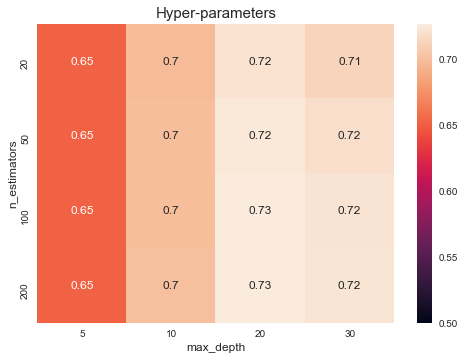

In [73]:
ax = sns.heatmap(rf_grid_scores, vmin=0.5, annot=True)
plt.title('Hyper-parameters', fontsize = 15) 
plt.xlabel('max_depth', fontsize = 12) 
plt.ylabel('n_estimators', fontsize = 12)

### Training size vs Accuracy for Random Forest

In [34]:
rf_reg_results = dict()
rf_score_results = dict()
for test_size in np.arange(0.1, 1, 0.1):
    seed_scores = []
    t0 = time.time()
    for seed in range(5):
        X_train, X_test, y_train, y_test, xvar_dict, groups = add_features(house_df,
                                                                           start_year=None,
                                                                           end_year=None,
                                                                           test_size=test_size,
                                                                           random_seed=seed)
        xvars = []
        for g in groups:
            xvars += xvar_dict[g]
        X_train_tmp, X_test_tmp = X_train[xvars], X_test[xvars]
        rf_reg = RandomForestRegressor(n_estimators=20, max_depth=20, random_state=42)
        rf_reg.fit(X_train_tmp, y_train)
        mse = metrics.mean_squared_error(y_test, rf_reg.predict(X_test_tmp))
        rf_reg_results[test_size] = rf_reg
        seed_scores.append(1 - metrics.mean_squared_error(y_test, rf_reg.predict(X_test_tmp)) / y_test.var())
    print(f"{test_size} used {time.time()-t0} seconds")
    rf_score_results[test_size] = np.mean(seed_scores)

0.1 used 222.8013231754303 seconds
0.2 used 200.98380088806152 seconds
0.30000000000000004 used 169.13391184806824 seconds
0.4 used 145.50199818611145 seconds
0.5 used 123.2381649017334 seconds
0.6 used 96.49885702133179 seconds
0.7000000000000001 used 74.21032810211182 seconds
0.8 used 54.985050201416016 seconds
0.9 used 36.28480815887451 seconds


Text(0, 0.5, 'scores')

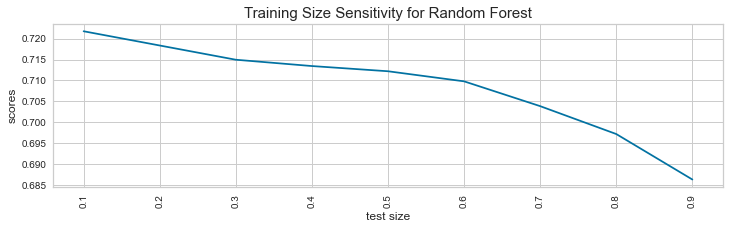

In [35]:
size_sensitivity_rf = pd.Series(rf_score_results).sort_index()

fig, ax = plt.subplots(figsize=[12,3])
ax.plot(size_sensitivity_rf)
ax.set_xticks(size_sensitivity_rf.index)
ax.set_xticklabels(np.round(size_sensitivity_rf.index, 2), rotation=90)
plt.title('Training Size Sensitivity for Random Forest', fontsize = 15) 
plt.xlabel('test size', fontsize = 12) 
plt.ylabel('scores', fontsize = 12)

### Year Sensitivity for Random Forest

In [38]:
rf_year_reg_results = dict()
rf_year_score_results = dict()
for start_year in np.arange(2000, 2019, 1):
    X_train, X_test, y_train, y_test, xvar_dict, groups = add_features(house_df,
                                                                       start_year=start_year,
                                                                       end_year=None)
    xvars = []
    for g in groups:
        xvars += xvar_dict[g]
    X_train_tmp, X_test_tmp = X_train[xvars], X_test[xvars]
    rf_reg = RandomForestRegressor(n_estimators=20, max_depth=20, random_state=42)
    rf_reg.fit(X_train_tmp, y_train)
    mse = metrics.mean_squared_error(y_test, rf_reg.predict(X_test_tmp))
    rf_year_reg_results[start_year] = rf_reg
    rf_year_score_results[start_year] = 1 - metrics.mean_squared_error(y_test, rf_reg.predict(X_test_tmp)) / y_test.var()
    

Text(0, 0.5, 'scores')

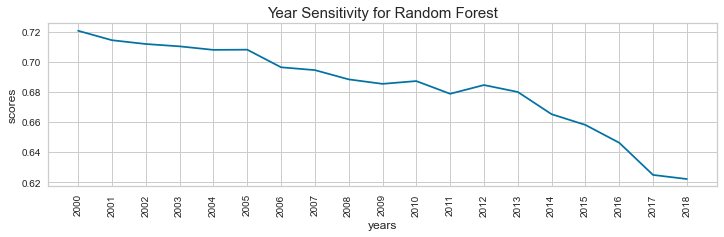

In [39]:
year_sensitivity_rf = pd.Series(rf_year_score_results).sort_index()

fig, ax = plt.subplots(figsize=[12,3])
ax.plot(year_sensitivity_rf)
ax.set_xticks(year_sensitivity_rf.index)
ax.set_xticklabels(np.round(year_sensitivity_rf.index, 2), rotation=90)
plt.title('Year Sensitivity for Random Forest', fontsize = 15) 
plt.xlabel('years', fontsize = 12) 
plt.ylabel('scores', fontsize = 12)

#### CV for Year Sensitivity for Random Forest

In [42]:
rf_year_reg_results = dict()
rf_year_score_results = dict()
for start_year in np.arange(2000, 2019, 1):
    X_train, X_test, y_train, y_test, xvar_dict, groups = add_features(house_df,
                                                                       start_year=start_year,
                                                                       end_year=None, test_size=0)
    xvars = []
    for g in groups:
        xvars += xvar_dict[g]
    X_train_tmp = X_train[xvars]
    rf_year_score_results[start_year] = create_rf_cv(X_train_tmp, y_train, xvars)

random forest cv used 198.03001976013184 seconds
random forest cv used 166.742693901062 seconds
random forest cv used 176.42827606201172 seconds
random forest cv used 138.67288899421692 seconds
random forest cv used 134.96927118301392 seconds
random forest cv used 133.04906010627747 seconds
random forest cv used 127.98462080955505 seconds
random forest cv used 121.64807319641113 seconds
random forest cv used 118.5472309589386 seconds
random forest cv used 114.5475537776947 seconds
random forest cv used 113.43890619277954 seconds
random forest cv used 109.06203603744507 seconds
random forest cv used 106.6186101436615 seconds
random forest cv used 113.47310590744019 seconds
random forest cv used 602.1810920238495 seconds
random forest cv used 91.82605385780334 seconds
random forest cv used 84.36754012107849 seconds
random forest cv used 76.10629487037659 seconds
random forest cv used 67.52456021308899 seconds


Text(0, 0.5, 'scores')

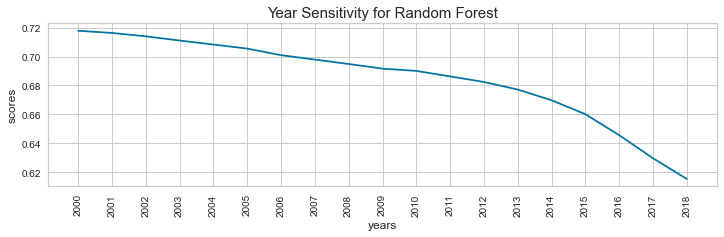

In [43]:
year_sensitivity_rf = pd.Series(rf_year_score_results).sort_index()

fig, ax = plt.subplots(figsize=[12,3])
ax.plot(year_sensitivity_rf)
ax.set_xticks(year_sensitivity_rf.index)
ax.set_xticklabels(np.round(year_sensitivity_rf.index, 2), rotation=90)
plt.title('Year Sensitivity for Random Forest', fontsize = 15) 
plt.xlabel('years', fontsize = 12) 
plt.ylabel('scores', fontsize = 12)

## Comparison of different models

## Gradient Boosted Decision Tree

In [44]:
X_train, X_test, y_train, y_test, xvar_dict, groups = add_features(house_df,
                                                                   start_year=None,
                                                                   end_year=None
                                                                  )
xvars = []
for g in groups:
    xvars += xvar_dict[g]
X_train_tmp, X_test_tmp = X_train[xvars], X_test[xvars]
gbc=GradientBoostingRegressor(n_estimators=50,learning_rate=0.05,random_state=100 )
gbc.fit(X_train_tmp, y_train)
full_model = gbc
gbc_y_pred = full_model.predict(X_test_tmp)
gbc_full_score = gbc.score(X_test_tmp, y_test)

In [45]:
expl_clf = explained_variance_score(gbc_y_pred, y_test)
expl_clf

0.29381131392447135

In [46]:
gbc_full_score

0.6579124907690992

## Logistic Regression

Logistic Regression is used when the dependent variable(target) is categorical.

For example,

To predict whether an email is spam (1) or (0)
Whether the tumor is malignant (1) or not (0)

## Ridge Regression

In [47]:

X_train, X_test, y_train, y_test, xvar_dict, groups = add_features(house_df,
                                                                   start_year=None,
                                                                   end_year=None
                                                                  )
xvars = []
for g in groups:
    xvars += xvar_dict[g]
X_train_tmp, X_test_tmp = X_train[xvars], X_test[xvars]
clf = Ridge(alpha=1)
clf.fit(X_train_tmp, y_train)
full_model = clf
clf_y_pred = full_model.predict(X_test_tmp)
clf_full_score = clf.score(X_test_tmp, y_test)
expl_clf = explained_variance_score(clf_y_pred, y_test)

In [48]:
expl_clf

0.5564980839942224

In [49]:
clf_full_score

0.6937350068117152

## Lasso

In [50]:

X_train, X_test, y_train, y_test, xvar_dict, groups = add_features(house_df,
                                                                   start_year=None,
                                                                   end_year=None
                                                                  )
xvars = []
for g in groups:
    xvars += xvar_dict[g]
X_train_tmp, X_test_tmp = X_train[xvars], X_test[xvars]
lasso_rg = linear_model.Lasso(alpha=0.0001)
lasso_rg.fit(X_train_tmp, y_train)
full_model = lasso_rg
lasso_y_pred = full_model.predict(X_test_tmp)
lasso_full_score = lasso_rg.score(X_test_tmp, y_test)

In [51]:
expl_lasso = explained_variance_score(lasso_y_pred, y_test)

In [52]:
expl_lasso

0.5489104355599048

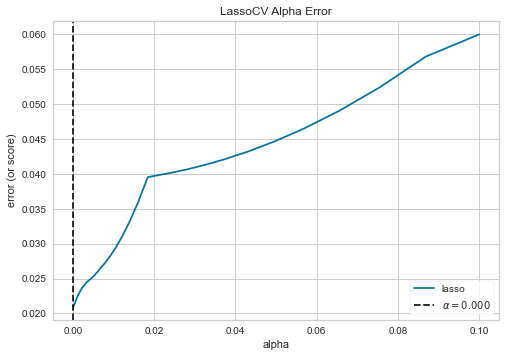

<AxesSubplot:title={'center':'LassoCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [53]:

alphas = np.logspace(-4, -1, 50)
lasso_rg = LassoCV(alphas=alphas)
visualizer = AlphaSelection(lasso_rg)
visualizer.fit(X_train_tmp, y_train)
visualizer.show()

In [54]:
lasso_full_score

0.6927226285751945

## KNN

In [55]:

X_train, X_test, y_train, y_test, xvar_dict, groups = add_features(house_df,
                                                                   start_year=None,
                                                                   end_year=None
                                                                  )
xvars = []
for g in groups:
    xvars += xvar_dict[g]
X_train_tmp, X_test_tmp = X_train[xvars], X_test[xvars]
neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(X_train_tmp, y_train)
full_model = neigh
knn_y_pred = full_model.predict(X_test_tmp)
knn_full_score = neigh.score(X_test_tmp, y_test)
expl_knn = explained_variance_score(knn_y_pred, y_test)

In [56]:
expl_knn

0.23135389210725454

In [57]:
knn_full_score

0.5735382794825477

### Decision Tree

In [58]:

X_train, X_test, y_train, y_test, xvar_dict, groups = add_features(house_df,
                                                                   start_year=None,
                                                                   end_year=None
                                                                  )
xvars = []
for g in groups:
    xvars += xvar_dict[g]
X_train_tmp, X_test_tmp = X_train[xvars], X_test[xvars]
dr_reg = DecisionTreeRegressor(random_state=42).fit(X_train_tmp, y_train)
dr_score = dr_reg.score(X_test_tmp, y_test)
dr_y_pred = dr_reg.predict(X_test_tmp)
expl_dr = explained_variance_score(dr_y_pred, y_test)
print(dr_score, expl_dr)

0.45919139223100247 0.480907897198826


### Comparison Table

In [59]:
comparison = pd.DataFrame(columns=['Accuracy Score','Explained Variance Score','Mean Absolute Error',\
                                   'Mean Squared Error','Root Mean Squared Error'],
                         index = ['Linear Regression', 'Random Forest', \
                                  'Gradient Boosted Decision Tree','Ridge Regression',
                                 'Lasso','KNN', 'Decision Tree'])


In [66]:
comparison.loc['Linear Regression', :] = [lr_full_score,explained_variance_score(rg_y_pred, y_test),\
                                          metrics.mean_absolute_error(y_test, rg_y_pred),\
metrics.mean_squared_error(y_test, rg_y_pred),
np.sqrt(metrics.mean_squared_error(y_test, rg_y_pred))]

comparison.loc['Random Forest', :] = [rf_full_score,explained_variance_score(rf_y_pred, y_test),\
                                      metrics.mean_absolute_error(y_test, rf_y_pred),\
metrics.mean_squared_error(y_test, rf_y_pred),
np.sqrt(metrics.mean_squared_error(y_test, rf_y_pred))]

comparison.loc['Gradient Boosted Decision Tree', :] = [gbc_full_score,explained_variance_score(gbc_y_pred, y_test),\
                                                       metrics.mean_absolute_error(y_test, gbc_y_pred),\
metrics.mean_squared_error(y_test, gbc_y_pred),
np.sqrt(metrics.mean_squared_error(y_test, gbc_y_pred))]


comparison.loc['Ridge Regression', :] = [clf_full_score,explained_variance_score(clf_y_pred, y_test),\
                                         metrics.mean_absolute_error(y_test, clf_y_pred),\
metrics.mean_squared_error(y_test, clf_y_pred),
np.sqrt(metrics.mean_squared_error(y_test, clf_y_pred))]

comparison.loc['Lasso', :] = [lasso_full_score,explained_variance_score(lasso_y_pred, y_test),\
                              metrics.mean_absolute_error(y_test, lasso_y_pred),\
metrics.mean_squared_error(y_test, lasso_y_pred),
np.sqrt(metrics.mean_squared_error(y_test, lasso_y_pred))]

comparison.loc['KNN', :] = [knn_full_score,explained_variance_score(knn_y_pred, y_test),\
                            metrics.mean_absolute_error(y_test, knn_y_pred),\
metrics.mean_squared_error(y_test, knn_y_pred),
np.sqrt(metrics.mean_squared_error(y_test, knn_y_pred))]


comparison.loc['Decision Tree', :] = [dr_score,explained_variance_score(dr_y_pred, y_test),\
                                      metrics.mean_absolute_error(y_test, dr_y_pred),\
metrics.mean_squared_error(y_test, dr_y_pred),
np.sqrt(metrics.mean_squared_error(y_test, dr_y_pred))]


In [67]:
comparison.sort_values(['Accuracy Score'], ascending=False)

,Accuracy Score,Explained Variance Score,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error
Random Forest,0.720548,0.625524,0.089025,0.018606,0.136404
Ridge Regression,0.693735,0.556498,0.097085,0.020391,0.142798
Lasso,0.692723,0.54891,0.097468,0.020459,0.143034
Linear Regression,0.689237,0.556594,0.097082,0.020391,0.142798
Gradient Boosted Decision Tree,0.657912,0.293811,0.106248,0.022776,0.150919
KNN,0.573538,0.231354,0.120943,0.028394,0.168506
Decision Tree,0.459191,0.480908,0.120814,0.036007,0.189756
